# Modelo Random Forest con Preprocesado Alternativo

- Sergio Andres Daza
- Antonia Yepes Quintero

Este notebook implementa un modelo Random Forest utilizando un preprocesado alternativo al utilizado en el modelo RandomForest.

## 1. Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Función de preprocesado alternativo

Este preprocesado difiere del modelo SVM en varios aspectos:
- Mantiene más variables categóricas sin one-hot encoding
- Usa RobustScaler en lugar de StandardScaler
- Crea nuevas características (feature engineering)
- Manejo diferente de valores atípicos

In [ ]:
def preprocesar_datos_rf(df, es_train=True, encoders=None, scaler=None):

    df_procesado = df.copy()
    
    print("Aplicando preprocesado alternativo para Random Forest...")
    
    # 1. Procesar RENDIMIENTO_GLOBAL solo si es train
    if es_train and 'RENDIMIENTO_GLOBAL' in df_procesado.columns:
        print("Procesando variable target...")
        mapeo_rendimiento = {
            'bajo': 0,
            'medio-bajo': 1,
            'medio-alto': 2,
            'alto': 3
        }
        df_procesado['RENDIMIENTO_GLOBAL'] = df_procesado['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
    
    # 2. Feature Engineering - Crear nuevas características
    print("Creando nuevas características...")
    
    # 3. Procesar ESTU_HORASSEMANATRABAJA de forma más granular
    print("Procesando horas de trabajo (versión mejorada)...")
    def procesar_horas_trabajo_rf(valor):
        if pd.isnull(valor):
            return -1  # Categoría especial para missing
        valor = str(valor).strip()
        if valor == "0":
            return 0
        elif "Menos de" in valor:
            numeros = re.findall(r'\d+', valor)
            return int(numeros[0]) if numeros else 5  # Promedio bajo
        elif "Más de" in valor:
            numeros = re.findall(r'\d+', valor)
            return int(numeros[0]) + 5 if numeros else 35  # Más alto
        else:
            numeros = re.findall(r'\d+', valor)
            if len(numeros) == 2:
                return int((int(numeros[0]) + int(numeros[1])) / 2)
            elif len(numeros) == 1:
                return int(numeros[0])
            else:
                return -1
    
    df_procesado['ESTU_HORASSEMANATRABAJA'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(procesar_horas_trabajo_rf)
    
    # Crear categorías de trabajo
    def categorizar_trabajo(horas):
        if horas == -1:
            return 'no_especificado'
        elif horas == 0:
            return 'no_trabaja'
        elif horas <= 10:
            return 'trabajo_parcial'
        elif horas <= 30:
            return 'trabajo_medio'
        else:
            return 'trabajo_intenso'
    
    df_procesado['CATEGORIA_TRABAJO'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(categorizar_trabajo)
    
    # 4. Procesar ESTU_VALORMATRICULAUNIVERSIDAD con manejo de outliers
    print("Procesando valor matrícula (con outliers)...")
    def extraer_promedio_robusto(valor_str):
        if pd.isnull(valor_str):
            return -1  # Valor especial para missing
        numeros = re.findall(r"(\d+\.*\d*)", str(valor_str))
        if len(numeros) >= 2:
            min_val = float(numeros[0])
            max_val = float(numeros[1])
            promedio = (min_val + max_val) / 2
            # Aplicar log para manejar outliers
            return np.log1p(promedio)
        else:
            return -1
    
    df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(extraer_promedio_robusto)
    
    # 5. Procesar FAMI_ESTRATOVIVIENDA manteniendo información ordinal
    print("Procesando estrato vivienda (ordinal)...")
    def procesar_estrato(valor):
        if pd.isnull(valor):
            return 0
        valor_str = str(valor).lower().replace('estrato', '').strip()
        if 'sin' in valor_str:
            return 0
        try:
            return int(valor_str)
        except:
            return 0
    
    df_procesado['FAMI_ESTRATOVIVIENDA'] = df_procesado['FAMI_ESTRATOVIVIENDA'].apply(procesar_estrato)
    
    # 6. Procesar variables binarias
    print("Procesando variables binarias...")
    if 'FAMI_TIENEINTERNET' in df_procesado.columns:
        df_procesado['FAMI_TIENEINTERNET'] = df_procesado['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0}).fillna(0)
    if 'ESTU_PAGOMATRICULAPROPIO' in df_procesado.columns:
        df_procesado['ESTU_PAGOMATRICULAPROPIO'] = df_procesado['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0}).fillna(0)
    
    # 7. Label encoding para educación (manteniendo orden pero como numérico)
    print("Aplicando label encoding mejorado...")
    orden_educacion = [
        "No aplica", "No sabe", "Ninguno", "Primaria incompleta", "Primaria completa",
        "Secundaria (Bachillerato) incompleta", "Secundaria (Bachillerato) completa",
        "Técnica o tecnológica incompleta", "Técnica o tecnológica completa",
        "Educación profesional incompleta", "Educación profesional completa", "Postgrado"
    ]
    educacion_map = {nivel: idx for idx, nivel in enumerate(orden_educacion)}
    
    if 'FAMI_EDUCACIONPADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONPADRE'] = df_procesado['FAMI_EDUCACIONPADRE'].map(educacion_map).fillna(0)
    if 'FAMI_EDUCACIONMADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONMADRE'] = df_procesado['FAMI_EDUCACIONMADRE'].map(educacion_map).fillna(0)
    
    # Feature engineering: educación promedio de padres
    if 'FAMI_EDUCACIONPADRE' in df_procesado.columns and 'FAMI_EDUCACIONMADRE' in df_procesado.columns:
        df_procesado['EDUCACION_PROMEDIO_PADRES'] = (
            df_procesado['FAMI_EDUCACIONPADRE'] + df_procesado['FAMI_EDUCACIONMADRE']
        ) / 2
        
        # Diferencia en educación de padres
        df_procesado['DIFERENCIA_EDUCACION_PADRES'] = abs(
            df_procesado['FAMI_EDUCACIONPADRE'] - df_procesado['FAMI_EDUCACIONMADRE']
        )
    
    # 8. Manejo de departamentos - Label encoding en lugar de one-hot
    print("Aplicando label encoding para departamentos...")
    if 'ESTU_PRGM_DEPARTAMENTO' in df_procesado.columns:
        if es_train:
            le_depto = LabelEncoder()
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(
                df_procesado['ESTU_PRGM_DEPARTAMENTO'].fillna('UNKNOWN')
            )
            if encoders is None:
                encoders = {}
            encoders['ESTU_PRGM_DEPARTAMENTO'] = le_depto
        else:
            # Para test, usar encoder del train
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = df_procesado['ESTU_PRGM_DEPARTAMENTO'].fillna('UNKNOWN')
            # Manejar categorías no vistas
            known_classes = set(encoders['ESTU_PRGM_DEPARTAMENTO'].classes_)
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = df_procesado['ESTU_PRGM_DEPARTAMENTO'].apply(
                lambda x: x if x in known_classes else 'UNKNOWN'
            )
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = encoders['ESTU_PRGM_DEPARTAMENTO'].transform(
                df_procesado['ESTU_PRGM_DEPARTAMENTO']
            )
    
    # 9. Manejo de programas académicos - Agrupamiento más agresivo
    print("Procesando programas académicos con agrupamiento...")
    if 'ESTU_PRGM_ACADEMICO' in df_procesado.columns:
        def agrupar_programa(programa):
            if pd.isnull(programa):
                return 'OTRO'
            
            programa = str(programa).upper()
            
            # Agrupaciones por áreas del conocimiento
            if any(word in programa for word in ['MEDICINA', 'ENFERMERIA', 'ODONTOLOGIA', 'SALUD']):
                return 'CIENCIAS_SALUD'
            elif any(word in programa for word in ['INGENIERIA', 'SISTEMAS', 'INDUSTRIAL', 'CIVIL']):
                return 'INGENIERIA'
            elif any(word in programa for word in ['ADMINISTRACION', 'NEGOCIOS', 'ECONOMIA', 'CONTADURIA']):
                return 'ADMINISTRACION_ECONOMIA'
            elif any(word in programa for word in ['DERECHO', 'JURIDICA']):
                return 'DERECHO'
            elif any(word in programa for word in ['EDUCACION', 'PEDAGOGIA']):
                return 'EDUCACION'
            elif any(word in programa for word in ['PSICOLOGIA', 'SOCIAL']):
                return 'CIENCIAS_SOCIALES'
            elif any(word in programa for word in ['ARTE', 'MUSICA', 'DISEÑO']):
                return 'ARTES'
            else:
                return 'OTRO'
        
        df_procesado['AREA_CONOCIMIENTO'] = df_procesado['ESTU_PRGM_ACADEMICO'].apply(agrupar_programa)
        
        # Label encoding para áreas
        if es_train:
            le_area = LabelEncoder()
            df_procesado['AREA_CONOCIMIENTO'] = le_area.fit_transform(df_procesado['AREA_CONOCIMIENTO'])
            if encoders is None:
                encoders = {}
            encoders['AREA_CONOCIMIENTO'] = le_area
        else:
            df_procesado['AREA_CONOCIMIENTO'] = encoders['AREA_CONOCIMIENTO'].transform(
                df_procesado['AREA_CONOCIMIENTO']
            )
        
        # Eliminar la columna original
        df_procesado = df_procesado.drop('ESTU_PRGM_ACADEMICO', axis=1)
    
    # 10. Procesar PERIODO de forma diferente
    print("Procesando periodo...")
    if 'PERIODO' in df_procesado.columns:
        df_procesado['PERIODO'] = df_procesado['PERIODO'].astype(str)
        df_procesado['PERIODO_ANO'] = df_procesado['PERIODO'].str[:4].astype(int)
        df_procesado['PERIODO_NUM'] = df_procesado['PERIODO'].str[-1].astype(int)
        
        # Feature engineering: años desde el primer año del dataset
        min_ano = df_procesado['PERIODO_ANO'].min()
        df_procesado['ANOS_DESDE_INICIO'] = df_procesado['PERIODO_ANO'] - min_ano
        
        df_procesado = df_procesado.drop('PERIODO', axis=1)
    
    # 11. Label encoding para categoría de trabajo
    if 'CATEGORIA_TRABAJO' in df_procesado.columns:
        if es_train:
            le_trabajo = LabelEncoder()
            df_procesado['CATEGORIA_TRABAJO'] = le_trabajo.fit_transform(df_procesado['CATEGORIA_TRABAJO'])
            if encoders is None:
                encoders = {}
            encoders['CATEGORIA_TRABAJO'] = le_trabajo
        else:
            df_procesado['CATEGORIA_TRABAJO'] = encoders['CATEGORIA_TRABAJO'].transform(
                df_procesado['CATEGORIA_TRABAJO']
            )
    
    # 12. Escalado robusto solo para variables continuas
    print("Aplicando escalado robusto...")
    columnas_a_escalar = [
        'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
        'EDUCACION_PROMEDIO_PADRES', 'DIFERENCIA_EDUCACION_PADRES',
        'PERIODO_ANO', 'ANOS_DESDE_INICIO'
    ]
    
    # Filtrar solo las columnas que existen
    columnas_existentes = [col for col in columnas_a_escalar if col in df_procesado.columns]
    
    if columnas_existentes:
        if es_train:
            scaler = RobustScaler()
            df_procesado[columnas_existentes] = scaler.fit_transform(df_procesado[columnas_existentes])
        else:
            df_procesado[columnas_existentes] = scaler.transform(df_procesado[columnas_existentes])
    
    # 13. Imputación final de valores faltantes
    print("Imputación final...")
    # Random Forest maneja bien los NaN, pero por seguridad los rellenamos
    for col in df_procesado.columns:
        if df_procesado[col].dtype in ['object']:
            df_procesado[col] = df_procesado[col].fillna('UNKNOWN')
        else:
            df_procesado[col] = df_procesado[col].fillna(-1)  # Valor especial para missing
    
    # 14. Remover ID si existe y es entrenamiento
    if 'ID' in df_procesado.columns and es_train:
        df_procesado = df_procesado.drop('ID', axis=1)
    
    print(f"Preprocesado completado. Shape final: {df_procesado.shape}")
    
    if es_train:
        return df_procesado, encoders, scaler
    else:
        return df_procesado

print("Función de preprocesado alternativo definida")

Función de preprocesado alternativo definida


## 3. Cargar y preprocesar datos de entrenamiento

In [3]:
# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
df_train = pd.read_csv("train.csv")

print(f"Datos originales - Filas: {df_train.shape[0]}, Columnas: {df_train.shape[1]}")
print(f"Distribución de clases en datos originales:")
print(df_train['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

# Aplicar preprocesado alternativo
df_procesado, encoders_entrenamiento, scaler_entrenamiento = preprocesar_datos_rf(df_train, es_train=True)

print(f"\nDatos procesados - Filas: {df_procesado.shape[0]}, Columnas: {df_procesado.shape[1]}")
print(f"Distribución de clases después del preprocesado:")
print(df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

Cargando datos de entrenamiento...
Datos originales - Filas: 692500, Columnas: 12
Distribución de clases en datos originales:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64
Aplicando preprocesado alternativo para Random Forest...
Procesando variable target...
Creando nuevas características...
Procesando horas de trabajo (versión mejorada)...
Procesando valor matrícula (con outliers)...
Procesando estrato vivienda (ordinal)...
Procesando variables binarias...
Aplicando label encoding mejorado...
Aplicando label encoding para departamentos...
Procesando programas académicos con agrupamiento...
Procesando periodo...
Aplicando escalado robusto...
Imputación final...
Preprocesado completado. Shape final: (692500, 16)

Datos procesados - Filas: 692500, Columnas: 16
Distribución de clases después del preprocesado:
RENDIMIENTO_GLOBAL
0    172987
1    172275
2    171619
3    175619
Name: count, dtype: int64


## 4. Análisis exploratorio post-preprocesado

Valores nulos después del preprocesado:
Total de valores nulos: 0

Nuevas características creadas:
  - CATEGORIA_TRABAJO: 5 valores únicos
  - EDUCACION_PROMEDIO_PADRES: 23 valores únicos
  - DIFERENCIA_EDUCACION_PADRES: 12 valores únicos
  - AREA_CONOCIMIENTO: 8 valores únicos
  - ANOS_DESDE_INICIO: 4 valores únicos


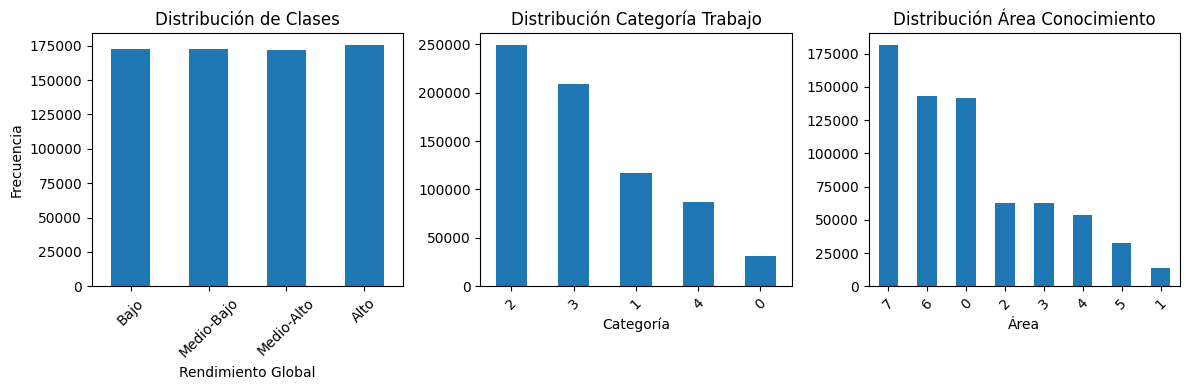


Balance de clases:
Bajo: 0.250 (25.0%)
Medio-Bajo: 0.249 (24.9%)
Medio-Alto: 0.248 (24.8%)
Alto: 0.254 (25.4%)


In [4]:
# Verificar valores nulos después del preprocesado
print("Valores nulos después del preprocesado:")
nulos_totales = df_procesado.isnull().sum().sum()
print(f"Total de valores nulos: {nulos_totales}")

if nulos_totales > 0:
    print("\nColumnas con valores nulos:")
    columnas_con_nulos = df_procesado.isnull().sum()
    print(columnas_con_nulos[columnas_con_nulos > 0])

# Mostrar nuevas características creadas
print("\nNuevas características creadas:")
nuevas_caracteristicas = [
    'CATEGORIA_TRABAJO', 'EDUCACION_PROMEDIO_PADRES', 
    'DIFERENCIA_EDUCACION_PADRES', 'AREA_CONOCIMIENTO', 'ANOS_DESDE_INICIO'
]
for col in nuevas_caracteristicas:
    if col in df_procesado.columns:
        print(f"  - {col}: {df_procesado[col].nunique()} valores únicos")

# Análisis de la distribución de clases
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Rendimiento Global')
plt.ylabel('Frecuencia')
plt.xticks([0, 1, 2, 3], ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], rotation=45)

plt.subplot(1, 3, 2)
if 'CATEGORIA_TRABAJO' in df_procesado.columns:
    df_procesado['CATEGORIA_TRABAJO'].value_counts().plot(kind='bar')
    plt.title('Distribución Categoría Trabajo')
    plt.xlabel('Categoría')
    plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
if 'AREA_CONOCIMIENTO' in df_procesado.columns:
    df_procesado['AREA_CONOCIMIENTO'].value_counts().plot(kind='bar')
    plt.title('Distribución Área Conocimiento')
    plt.xlabel('Área')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nBalance de clases:")
proporciones = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index()
for i, prop in enumerate(proporciones):
    clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
    print(f"{clases[i]}: {prop:.3f} ({prop*100:.1f}%)")

## 5. Preparación de datos para el modelo

In [5]:
# Separar features y target
X = df_procesado.drop(['RENDIMIENTO_GLOBAL'], axis=1)
y = df_procesado['RENDIMIENTO_GLOBAL']

print(f"Dimensiones finales:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")

# División train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisión de datos:")
print(f"Training: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")

# Verificar distribución en cada conjunto
print(f"\nDistribución en training:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nDistribución en validation:")
print(y_val.value_counts(normalize=True).sort_index())

# Mostrar información sobre las características
print(f"\nInformación de características:")
print(f"Total de características: {X.shape[1]}")
print(f"Características numéricas: {X.select_dtypes(include=[np.number]).shape[1]}")
print(f"Características categóricas: {X.select_dtypes(include=['object']).shape[1]}")

Dimensiones finales:
X (features): (692500, 15)
y (target): (692500,)

División de datos:
Training: 554000 muestras
Validation: 138500 muestras

Distribución en training:
RENDIMIENTO_GLOBAL
0    0.249801
1    0.248773
2    0.247825
3    0.253601
Name: proportion, dtype: float64

Distribución en validation:
RENDIMIENTO_GLOBAL
0    0.249798
1    0.248773
2    0.247827
3    0.253603
Name: proportion, dtype: float64

Información de características:
Total de características: 15
Características numéricas: 15
Características categóricas: 0


## 6. Submuestreo para desarrollo rápido

Para acelerar el desarrollo, reducimos el tamaño del dataset.

In [6]:
print("=== SUBMUESTREO PARA DESARROLLO RÁPIDO ===")

# Reducir dataset para Random Forest (más rápido que SVM)
SAMPLE_SIZE = 80000  # RF puede manejar más datos eficientemente

if X_train.shape[0] > SAMPLE_SIZE:
    print(f"🔥 Reduciendo dataset de {X_train.shape[0]} a {SAMPLE_SIZE} muestras")
    
    # Submuestreo estratificado
    X_train_fast, _, y_train_fast, _ = train_test_split(
        X_train, y_train, 
        train_size=SAMPLE_SIZE,
        stratify=y_train,
        random_state=42
    )
    
    # Reemplazar variables
    X_train = X_train_fast
    y_train = y_train_fast
    
    print(f"✅ Nuevo tamaño: {X_train.shape}")
    print(f"✅ Random Forest es más eficiente que SVM")
else:
    print(f"✅ Dataset ya está en tamaño manejable: {X_train.shape}")

# También reducir validación
VAL_SAMPLE_SIZE = 15000

if X_val.shape[0] > VAL_SAMPLE_SIZE:
    print(f"🔥 Reduciendo validación de {X_val.shape[0]} a {VAL_SAMPLE_SIZE} muestras")
    
    X_val_fast, _, y_val_fast, _ = train_test_split(
        X_val, y_val, 
        train_size=VAL_SAMPLE_SIZE,
        stratify=y_val,
        random_state=42
    )
    
    X_val = X_val_fast
    y_val = y_val_fast
    
    print(f"✅ Nuevo tamaño validación: {X_val.shape}")

print(f"\n📊 TAMAÑOS FINALES:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"⚡ Random Forest será más rápido que SVM")

=== SUBMUESTREO PARA DESARROLLO RÁPIDO ===
🔥 Reduciendo dataset de 554000 a 80000 muestras
✅ Nuevo tamaño: (80000, 15)
✅ Random Forest es más eficiente que SVM
🔥 Reduciendo validación de 138500 a 15000 muestras
✅ Nuevo tamaño validación: (15000, 15)

📊 TAMAÑOS FINALES:
Training: (80000, 15)
Validation: (15000, 15)
⚡ Random Forest será más rápido que SVM


## 7. Búsqueda de hiperparámetros con Grid Search

Optimizamos los hiperparámetros del Random Forest usando validación cruzada.

In [7]:
print("=== OPTIMIZACIÓN DE HIPERPARÁMETROS RANDOM FOREST ===")

# Grid de parámetros optimizado para Random Forest
param_grid = {
    'n_estimators': [100, 200],  # Número de árboles
    'max_depth': [10, 20, None],  # Profundidad máxima
    'min_samples_split': [2, 5],  # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2],   # Mínimo de muestras en hoja
    'max_features': ['sqrt', 'log2']  # Número de características por división
}

print(f"🔍 Parámetros a probar:")
for param, values in param_grid.items():
    print(f"   • {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n📊 Total de combinaciones: {total_combinations}")
print(f"⏱️ Tiempo estimado: {total_combinations * 2} minutos")

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Crear el modelo base
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,  # Usar todos los cores
    class_weight='balanced'  # Manejar desbalance de clases
)

# Grid Search
print(f"\n🚀 Iniciando Grid Search...")
import time
start_time = time.time()

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

end_time = time.time()
search_time = end_time - start_time

print(f"\n✅ Grid Search completado en {search_time:.1f} segundos")
print(f"\n🏆 MEJORES PARÁMETROS:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📈 MEJOR SCORE CV: {grid_search.best_score_:.4f}")

=== OPTIMIZACIÓN DE HIPERPARÁMETROS RANDOM FOREST ===
🔍 Parámetros a probar:
   • n_estimators: [100, 200]
   • max_depth: [10, 20, None]
   • min_samples_split: [2, 5]
   • min_samples_leaf: [1, 2]
   • max_features: ['sqrt', 'log2']

📊 Total de combinaciones: 48
⏱️ Tiempo estimado: 96 minutos

🚀 Iniciando Grid Search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Grid Search completado en 210.3 segundos

🏆 MEJORES PARÁMETROS:
   • max_depth: 10
   • max_features: sqrt
   • min_samples_leaf: 2
   • min_samples_split: 2
   • n_estimators: 200

📈 MEJOR SCORE CV: 0.3991


## 8. Evaluación detallada del mejor modelo

Accuracy en validación: 0.3967

Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.41      0.55      0.47      3747
  Medio-Bajo       0.32      0.26      0.28      3732
  Medio-Alto       0.30      0.19      0.23      3717
        Alto       0.49      0.58      0.53      3804

    accuracy                           0.40     15000
   macro avg       0.38      0.40      0.38     15000
weighted avg       0.38      0.40      0.38     15000



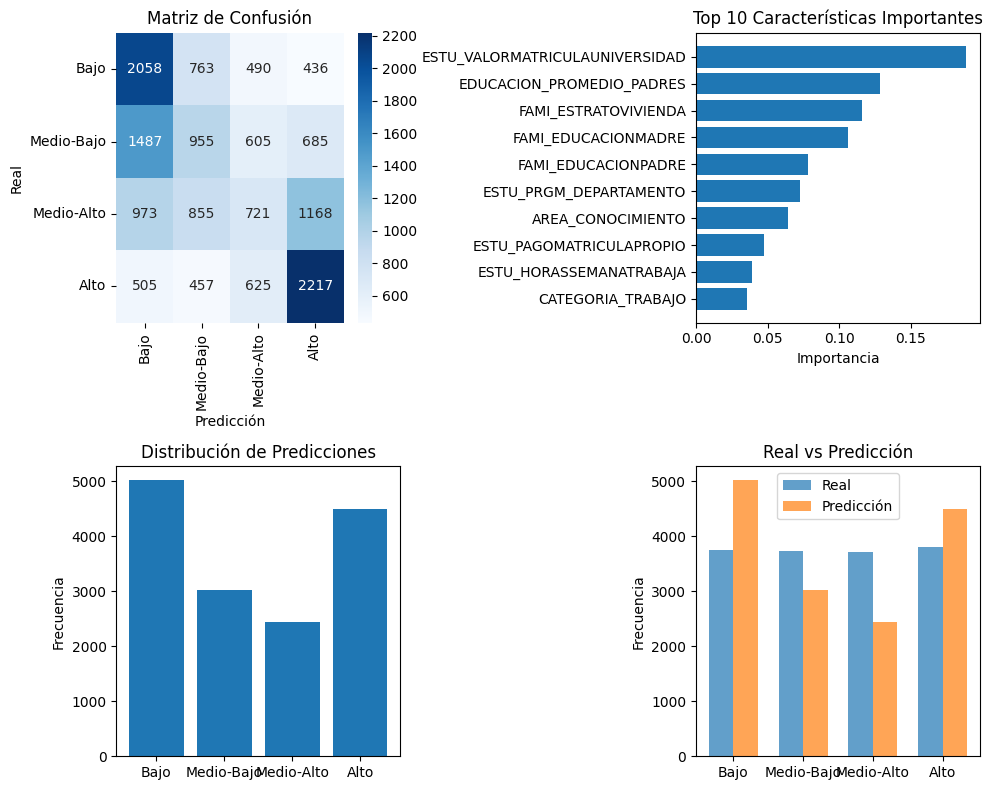


Análisis de errores por clase:
Bajo: 0.549 (3747 muestras)
Medio-Bajo: 0.256 (3732 muestras)
Medio-Alto: 0.194 (3717 muestras)
Alto: 0.583 (3804 muestras)

Top 15 características más importantes:
                       feature  importance
ESTU_VALORMATRICULAUNIVERSIDAD    0.188743
     EDUCACION_PROMEDIO_PADRES    0.128326
          FAMI_ESTRATOVIVIENDA    0.115670
           FAMI_EDUCACIONMADRE    0.105899
           FAMI_EDUCACIONPADRE    0.078342
        ESTU_PRGM_DEPARTAMENTO    0.072260
             AREA_CONOCIMIENTO    0.064449
      ESTU_PAGOMATRICULAPROPIO    0.047569
       ESTU_HORASSEMANATRABAJA    0.038928
             CATEGORIA_TRABAJO    0.035417
   DIFERENCIA_EDUCACION_PADRES    0.033431
            FAMI_TIENEINTERNET    0.031222
             ANOS_DESDE_INICIO    0.021578
                   PERIODO_ANO    0.021124
                   PERIODO_NUM    0.017042


In [8]:
# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Predicciones en el conjunto de validación
y_pred = best_rf.predict(X_val)

# Métricas de evaluación
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy en validación: {accuracy:.4f}")

# Reporte de clasificación detallado
clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred, target_names=clases))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Importancia de características
plt.subplot(2, 2, 2)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10 características más importantes
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 10 Características Importantes')
plt.gca().invert_yaxis()

# Distribución de predicciones
plt.subplot(2, 2, 3)
pred_counts = pd.Series(y_pred).value_counts().sort_index()
plt.bar(range(len(pred_counts)), pred_counts.values)
plt.xticks(range(len(pred_counts)), clases)
plt.title('Distribución de Predicciones')
plt.ylabel('Frecuencia')

# Comparación real vs predicción
plt.subplot(2, 2, 4)
real_counts = pd.Series(y_val).value_counts().sort_index()
x = range(len(clases))
width = 0.35
plt.bar([i - width/2 for i in x], real_counts.values, width, label='Real', alpha=0.7)
plt.bar([i + width/2 for i in x], pred_counts.values, width, label='Predicción', alpha=0.7)
plt.xticks(x, clases)
plt.title('Real vs Predicción')
plt.legend()
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Análisis de errores por clase
print("\nAnálisis de errores por clase:")
for i, clase in enumerate(clases):
    mask = y_val == i
    if mask.sum() > 0:
        accuracy_clase = (y_val[mask] == y_pred[mask]).mean()
        print(f"{clase}: {accuracy_clase:.3f} ({mask.sum()} muestras)")

# Mostrar las características más importantes
print("\nTop 15 características más importantes:")
print(feature_importance.head(15).to_string(index=False))

## 9. Análisis de importancia de características

=== ANÁLISIS DETALLADO DE CARACTERÍSTICAS ===

📊 IMPORTANCIA POR CATEGORÍAS:
   • Estudiante: 0.3475 (34.7%)
   • Educación: 0.3460 (34.6%)
   • Familia: 0.1469 (14.7%)
   • Académico: 0.0644 (6.4%)
   • Temporal: 0.0597 (6.0%)
   • Trabajo: 0.0354 (3.5%)


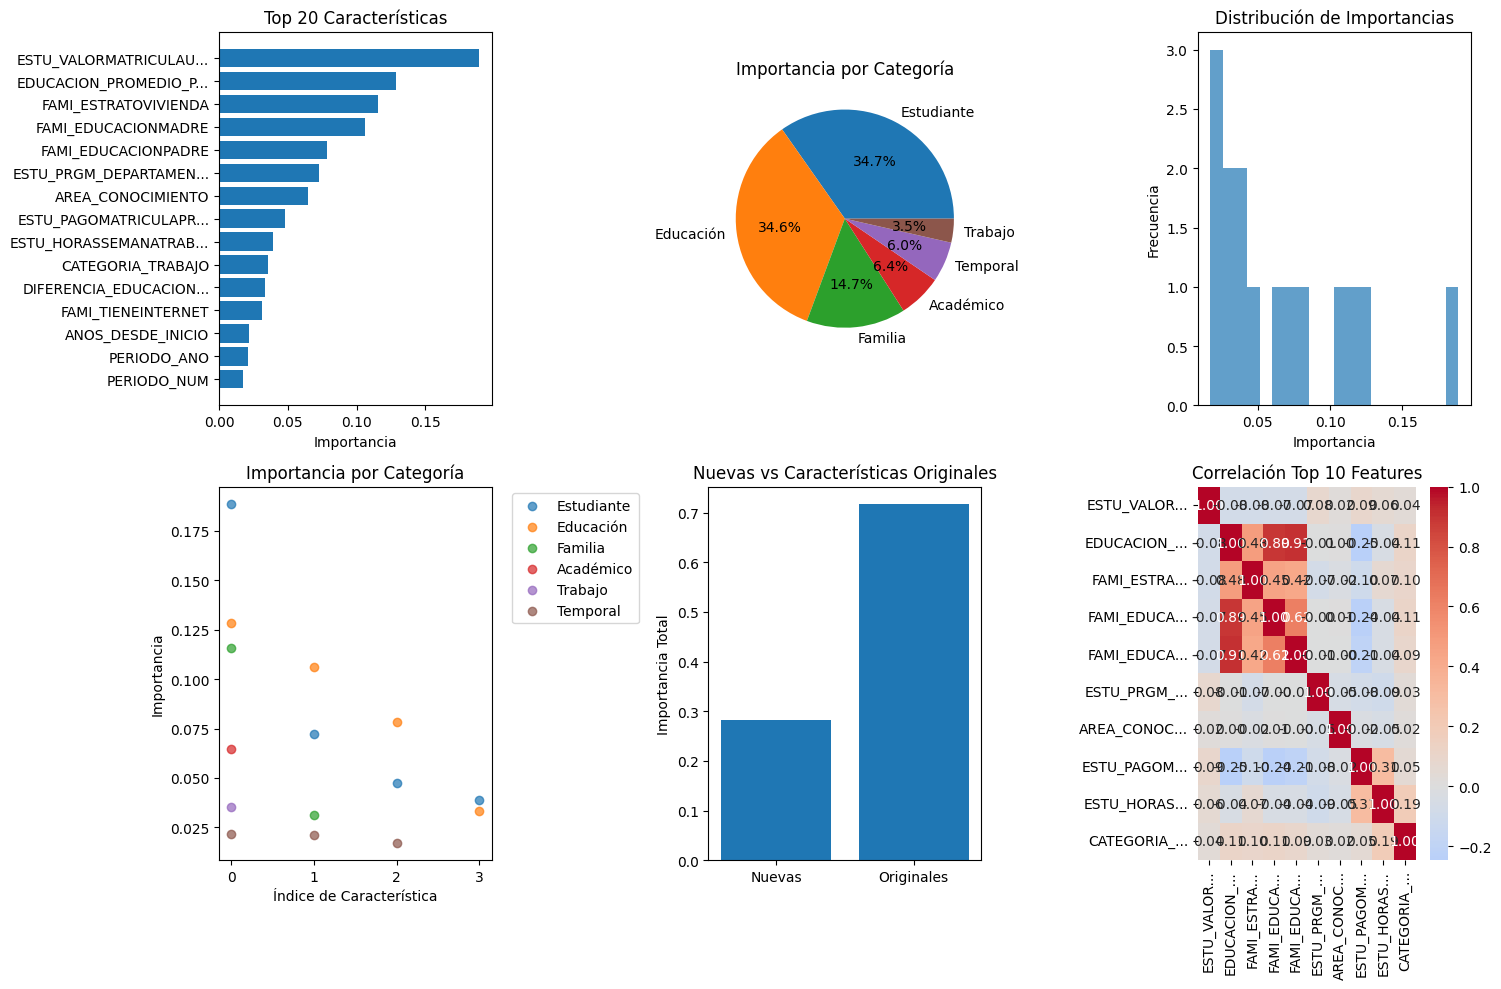


📈 ESTADÍSTICAS DE TOP 10 CARACTERÍSTICAS:
       ESTU_VALORMATRICULAUNIVERSIDAD  EDUCACION_PROMEDIO_PADRES  \
count                      692500.000                 692500.000   
mean                            0.078                     -0.003   
std                             0.674                      0.656   
min                            -0.732                     -1.500   
25%                            -0.732                     -0.500   
50%                             0.000                      0.000   
75%                             0.268                      0.500   
max                             1.643                      1.250   

       FAMI_ESTRATOVIVIENDA  FAMI_EDUCACIONMADRE  FAMI_EDUCACIONPADRE  \
count            692500.000           692500.000           692500.000   
mean                  2.404                6.186                5.794   
std                   1.218                2.822                3.012   
min                   0.000                0.000    

In [9]:
print("=== ANÁLISIS DETALLADO DE CARACTERÍSTICAS ===")

# Crear análisis más detallado de importancia
feature_analysis = pd.DataFrame({
    'caracteristica': X.columns,
    'importancia': best_rf.feature_importances_,
    'importancia_pct': best_rf.feature_importances_ * 100
}).sort_values('importancia', ascending=False)

# Categorizar características por tipo
def categorizar_caracteristica(nombre):
    if 'EDUCACION' in nombre:
        return 'Educación'
    elif 'FAMI_' in nombre:
        return 'Familia'
    elif 'ESTU_' in nombre:
        return 'Estudiante'
    elif 'PERIODO' in nombre or 'ANO' in nombre:
        return 'Temporal'
    elif 'TRABAJO' in nombre:
        return 'Trabajo'
    elif 'AREA' in nombre or 'PRGM' in nombre:
        return 'Académico'
    else:
        return 'Otro'

feature_analysis['categoria'] = feature_analysis['caracteristica'].apply(categorizar_caracteristica)

# Análisis por categorías
print("\n📊 IMPORTANCIA POR CATEGORÍAS:")
categoria_importancia = feature_analysis.groupby('categoria')['importancia'].sum().sort_values(ascending=False)
for categoria, importancia in categoria_importancia.items():
    print(f"   • {categoria}: {importancia:.4f} ({importancia*100:.1f}%)")

# Visualización de importancia por categorías
plt.figure(figsize=(15, 10))

# Gráfico 1: Top características
plt.subplot(2, 3, 1)
top_20 = feature_analysis.head(20)
plt.barh(range(len(top_20)), top_20['importancia'])
plt.yticks(range(len(top_20)), [f"{feat[:20]}..." if len(feat) > 20 else feat for feat in top_20['caracteristica']])
plt.xlabel('Importancia')
plt.title('Top 20 Características')
plt.gca().invert_yaxis()

# Gráfico 2: Importancia por categoría
plt.subplot(2, 3, 2)
plt.pie(categoria_importancia.values, labels=categoria_importancia.index, autopct='%1.1f%%')
plt.title('Importancia por Categoría')

# Gráfico 3: Distribución de importancias
plt.subplot(2, 3, 3)
plt.hist(feature_analysis['importancia'], bins=20, alpha=0.7)
plt.xlabel('Importancia')
plt.ylabel('Frecuencia')
plt.title('Distribución de Importancias')

# Gráfico 4: Características por categoría
plt.subplot(2, 3, 4)
for categoria in feature_analysis['categoria'].unique():
    cat_data = feature_analysis[feature_analysis['categoria'] == categoria]
    plt.scatter(range(len(cat_data)), cat_data['importancia'], label=categoria, alpha=0.7)
plt.xlabel('Índice de Característica')
plt.ylabel('Importancia')
plt.title('Importancia por Categoría')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico 5: Características nuevas vs originales
plt.subplot(2, 3, 5)
caracteristicas_nuevas = ['CATEGORIA_TRABAJO', 'EDUCACION_PROMEDIO_PADRES', 
                         'DIFERENCIA_EDUCACION_PADRES', 'AREA_CONOCIMIENTO', 'ANOS_DESDE_INICIO']
nuevas_importancia = feature_analysis[feature_analysis['caracteristica'].isin(caracteristicas_nuevas)]
originales_importancia = feature_analysis[~feature_analysis['caracteristica'].isin(caracteristicas_nuevas)]

plt.bar(['Nuevas', 'Originales'], 
        [nuevas_importancia['importancia'].sum(), originales_importancia['importancia'].sum()])
plt.title('Nuevas vs Características Originales')
plt.ylabel('Importancia Total')

# Gráfico 6: Correlación entre características top
plt.subplot(2, 3, 6)
top_10_features = feature_analysis.head(10)['caracteristica'].tolist()
correlation_matrix = X[top_10_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            xticklabels=[f"{feat[:10]}..." if len(feat) > 10 else feat for feat in top_10_features],
            yticklabels=[f"{feat[:10]}..." if len(feat) > 10 else feat for feat in top_10_features])
plt.title('Correlación Top 10 Features')

plt.tight_layout()
plt.show()

# Análisis estadístico de las características más importantes
print("\n📈 ESTADÍSTICAS DE TOP 10 CARACTERÍSTICAS:")
top_10_stats = X[top_10_features].describe()
print(top_10_stats.round(3))

# Mostrar características nuevas y su impacto
print("\n🆕 IMPACTO DE CARACTERÍSTICAS NUEVAS:")
if not nuevas_importancia.empty:
    print(nuevas_importancia[['caracteristica', 'importancia_pct']].to_string(index=False))
    print(f"\nImportancia total de características nuevas: {nuevas_importancia['importancia'].sum():.4f}")
else:
    print("No se encontraron características nuevas en el top de importancia")

## 10. Entrenamiento del modelo final

Entrenamos el modelo con todos los datos de entrenamiento para hacer predicciones en test.

In [10]:
print("=== ENTRENAMIENTO DEL MODELO FINAL ===")

# Combinar train y validation para el modelo final
print(f"🔄 Combinando datos de entrenamiento y validación...")
X_full = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_full = pd.concat([y_train, y_val], axis=0, ignore_index=True)

print(f"Datos combinados: {X_full.shape}")
print(f"Distribución final de clases:")
print(y_full.value_counts(normalize=True).sort_index())

# Entrenar el modelo final con los mejores parámetros
print(f"\n🤖 Entrenando Random Forest final...")
start_time = time.time()

modelo_final = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

modelo_final.fit(X_full, y_full)

end_time = time.time()
training_time = end_time - start_time
print(f"⏱️ Tiempo de entrenamiento: {training_time:.1f} segundos")

# Evaluar en el conjunto completo (como verificación)
train_accuracy = modelo_final.score(X_full, y_full)
print(f"✅ Accuracy en conjunto completo: {train_accuracy:.4f}")

# Análisis de importancia del modelo final
feature_importance_final = pd.DataFrame({
    'caracteristica': X_full.columns,
    'importancia': modelo_final.feature_importances_
}).sort_values('importancia', ascending=False)

print(f"\n📊 TOP 10 CARACTERÍSTICAS DEL MODELO FINAL:")
print(feature_importance_final.head(10).to_string(index=False))

print(f"\n📈 RESUMEN DEL MODELO FINAL:")
print(f"   • Muestras de entrenamiento: {X_full.shape[0]:,}")
print(f"   • Características: {X_full.shape[1]}")
print(f"   • Parámetros: {grid_search.best_params_}")
print(f"   • Accuracy: {train_accuracy:.4f}")
print(f"   • Tiempo de entrenamiento: {training_time:.1f}s")

print("\n✅ Modelo final entrenado exitosamente")

=== ENTRENAMIENTO DEL MODELO FINAL ===
🔄 Combinando datos de entrenamiento y validación...
Datos combinados: (95000, 15)
Distribución final de clases:
RENDIMIENTO_GLOBAL
0    0.249800
1    0.248779
2    0.247821
3    0.253600
Name: proportion, dtype: float64

🤖 Entrenando Random Forest final...
⏱️ Tiempo de entrenamiento: 2.6 segundos
✅ Accuracy en conjunto completo: 0.4574

📊 TOP 10 CARACTERÍSTICAS DEL MODELO FINAL:
                caracteristica  importancia
ESTU_VALORMATRICULAUNIVERSIDAD     0.194353
     EDUCACION_PROMEDIO_PADRES     0.133462
          FAMI_ESTRATOVIVIENDA     0.116813
           FAMI_EDUCACIONMADRE     0.107311
           FAMI_EDUCACIONPADRE     0.073885
        ESTU_PRGM_DEPARTAMENTO     0.071825
             AREA_CONOCIMIENTO     0.062337
      ESTU_PAGOMATRICULAPROPIO     0.048538
       ESTU_HORASSEMANATRABAJA     0.038159
             CATEGORIA_TRABAJO     0.033096

📈 RESUMEN DEL MODELO FINAL:
   • Muestras de entrenamiento: 95,000
   • Características: 15
  

## 11. Carga y preprocesamiento de datos de test

In [11]:
print("=== PROCESAMIENTO DE DATOS DE TEST ===")

# Cargar datos de test
print("Cargando datos de test...")
df_test = pd.read_csv("test.csv")
print(f"Datos de test - Filas: {df_test.shape[0]}, Columnas: {df_test.shape[1]}")

# Guardar IDs para el archivo de submission
test_ids = df_test['ID'].copy()

# Aplicar el mismo preprocesado que al entrenamiento
print("\nAplicando preprocesado alternativo a datos de test...")
df_test_procesado = preprocesar_datos_rf(
    df_test, 
    es_train=False, 
    encoders=encoders_entrenamiento,
    scaler=scaler_entrenamiento
)

print(f"Datos de test procesados - Filas: {df_test_procesado.shape[0]}, Columnas: {df_test_procesado.shape[1]}")

# Remover ID si existe
if 'ID' in df_test_procesado.columns:
    df_test_procesado = df_test_procesado.drop('ID', axis=1)

# Asegurar que test tenga las mismas columnas que train
missing_cols = set(X.columns) - set(df_test_procesado.columns)
extra_cols = set(df_test_procesado.columns) - set(X.columns)

print(f"\n🔍 Verificando consistencia de columnas:")
print(f"   • Columnas en train: {len(X.columns)}")
print(f"   • Columnas en test: {len(df_test_procesado.columns)}")

if missing_cols:
    print(f"   • Columnas faltantes en test: {len(missing_cols)}")
    print(f"     {list(missing_cols)[:5]}{'...' if len(missing_cols) > 5 else ''}")
    for col in missing_cols:
        df_test_procesado[col] = -1  # Valor especial para missing

if extra_cols:
    print(f"   • Columnas extra en test: {len(extra_cols)}")
    print(f"     {list(extra_cols)[:5]}{'...' if len(extra_cols) > 5 else ''}")
    df_test_procesado = df_test_procesado.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan
df_test_procesado = df_test_procesado[X.columns]

print(f"\n✅ Datos de test finales: {df_test_procesado.shape}")

# Verificar valores nulos o problemáticos
nulos_test = df_test_procesado.isnull().sum().sum()
infinitos_test = np.isinf(df_test_procesado.select_dtypes(include=[np.number])).sum().sum()

print(f"\n📊 Verificación final de test:")
print(f"   • Valores nulos: {nulos_test}")
print(f"   • Valores infinitos: {infinitos_test}")

if nulos_test > 0 or infinitos_test > 0:
    print("🔧 Limpiando valores problemáticos...")
    df_test_procesado = df_test_procesado.fillna(-1)
    df_test_procesado = df_test_procesado.replace([np.inf, -np.inf], [-1, -1])
    print("✅ Limpieza completada")

print(f"\n🎯 Test listo para predicciones: {df_test_procesado.shape}")

=== PROCESAMIENTO DE DATOS DE TEST ===
Cargando datos de test...
Datos de test - Filas: 296786, Columnas: 20

Aplicando preprocesado alternativo a datos de test...
Aplicando preprocesado alternativo para Random Forest...
Creando nuevas características...
Procesando horas de trabajo (versión mejorada)...
Procesando valor matrícula (con outliers)...
Procesando estrato vivienda (ordinal)...
Procesando variables binarias...
Aplicando label encoding mejorado...
Aplicando label encoding para departamentos...
Procesando programas académicos con agrupamiento...
Procesando periodo...
Aplicando escalado robusto...
Imputación final...
Preprocesado completado. Shape final: (296786, 25)
Datos de test procesados - Filas: 296786, Columnas: 25

🔍 Verificando consistencia de columnas:
   • Columnas en train: 15
   • Columnas en test: 24
   • Columnas extra en test: 9
     ['coef_3', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'coef_1', 'FAMI_TIENEAUTOMOVIL']...

✅ Datos de test finales: (296786, 15)


## 12. Predicciones en datos de test

=== REALIZANDO PREDICCIONES EN TEST ===
🎯 Prediciendo en 296,786 muestras...
⏱️ Tiempo de predicción: 2.5 segundos

📊 ANÁLISIS DE PREDICCIONES:
   • Bajo: 97,766 (32.9%)
   • Alto: 89,896 (30.3%)
   • Medio-bajo: 59,970 (20.2%)
   • Medio-alto: 49,154 (16.6%)

🎯 ANÁLISIS DE CONFIANZA:
   • Confianza promedio: 0.375
   • Confianza mínima: 0.250
   • Confianza máxima: 0.865


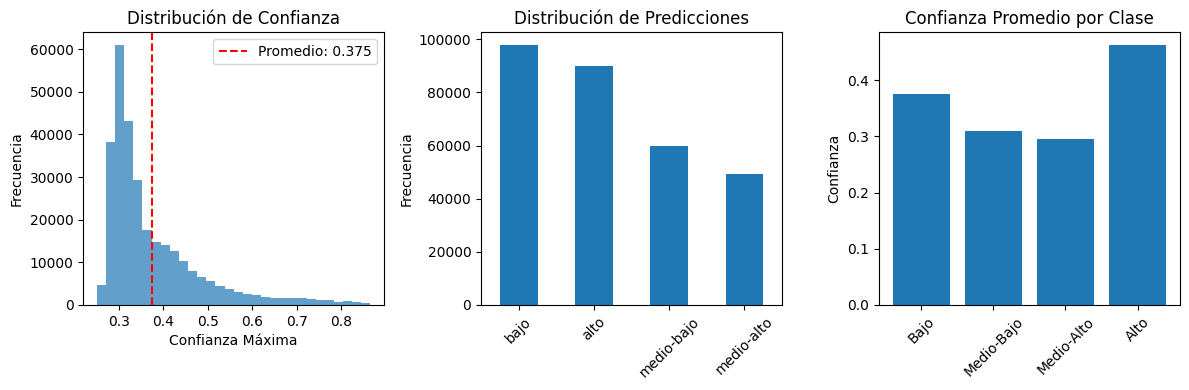


✅ Total de predicciones: 296,786
✅ Total de IDs de test: 296,786
✅ Predicciones completadas exitosamente


In [12]:
print("=== REALIZANDO PREDICCIONES EN TEST ===")

# Realizar predicciones
print(f"🎯 Prediciendo en {df_test_procesado.shape[0]:,} muestras...")
start_time = time.time()

predicciones_numericas = modelo_final.predict(df_test_procesado)

# También obtener probabilidades para análisis
predicciones_proba = modelo_final.predict_proba(df_test_procesado)

end_time = time.time()
prediction_time = end_time - start_time
print(f"⏱️ Tiempo de predicción: {prediction_time:.1f} segundos")

# Convertir predicciones numéricas a texto
mapeo_inverso = {
    0: 'bajo',
    1: 'medio-bajo', 
    2: 'medio-alto',
    3: 'alto'
}

predicciones_texto = [mapeo_inverso[pred] for pred in predicciones_numericas]

# Análisis de predicciones
print("\n📊 ANÁLISIS DE PREDICCIONES:")
pred_counts = pd.Series(predicciones_texto).value_counts()
for clase, count in pred_counts.items():
    porcentaje = (count / len(predicciones_texto)) * 100
    print(f"   • {clase.capitalize()}: {count:,} ({porcentaje:.1f}%)")

# Análisis de confianza de predicciones
max_probas = np.max(predicciones_proba, axis=1)
confianza_promedio = np.mean(max_probas)
print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
print(f"   • Confianza promedio: {confianza_promedio:.3f}")
print(f"   • Confianza mínima: {np.min(max_probas):.3f}")
print(f"   • Confianza máxima: {np.max(max_probas):.3f}")

# Distribución de confianza
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(max_probas, bins=30, alpha=0.7)
plt.xlabel('Confianza Máxima')
plt.ylabel('Frecuencia')
plt.title('Distribución de Confianza')
plt.axvline(confianza_promedio, color='red', linestyle='--', label=f'Promedio: {confianza_promedio:.3f}')
plt.legend()

plt.subplot(1, 3, 2)
pred_counts.plot(kind='bar')
plt.title('Distribución de Predicciones')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Confianza por clase
confianza_por_clase = []
for i, clase in enumerate(['bajo', 'medio-bajo', 'medio-alto', 'alto']):
    mask = predicciones_numericas == i
    if mask.sum() > 0:
        conf_clase = np.mean(max_probas[mask])
        confianza_por_clase.append(conf_clase)
    else:
        confianza_por_clase.append(0)

plt.bar(['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], confianza_por_clase)
plt.title('Confianza Promedio por Clase')
plt.ylabel('Confianza')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Total de predicciones: {len(predicciones_texto):,}")
print(f"✅ Total de IDs de test: {len(test_ids):,}")
print(f"✅ Predicciones completadas exitosamente")

## 13. Generación del archivo de submission

In [13]:
print("=== GENERANDO ARCHIVO DE SUBMISSION ===")

# Crear DataFrame de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': predicciones_texto
})

# Verificar formato del submission
print("\n📋 VERIFICACIÓN DEL SUBMISSION:")
print(f"   • Número de filas: {len(submission):,}")
print(f"   • Columnas: {list(submission.columns)}")
print(f"   • Valores únicos en RENDIMIENTO_GLOBAL: {sorted(submission['RENDIMIENTO_GLOBAL'].unique())}")

# Verificar que no hay valores nulos
nulos_submission = submission.isnull().sum()
print(f"\n🔍 Valores nulos en submission:")
for col, nulos in nulos_submission.items():
    print(f"   • {col}: {nulos}")

# Verificar que los IDs son únicos
ids_duplicados = submission['ID'].duplicated().sum()
print(f"\n🆔 IDs duplicados: {ids_duplicados}")

if ids_duplicados > 0:
    print("⚠️ ADVERTENCIA: Hay IDs duplicados en el submission")
else:
    print("✅ Todos los IDs son únicos")

# Mostrar primeras y últimas filas
print("\n📄 Primeras 10 filas del submission:")
print(submission.head(10))

print("\n📄 Últimas 5 filas del submission:")
print(submission.tail(5))

# Guardar archivo
nombre_archivo = "submission_random_forest.csv"
submission.to_csv(nombre_archivo, index=False)
print(f"\n💾 Archivo guardado como: {nombre_archivo}")

# Verificación final del archivo guardado
print("\n🔎 VERIFICACIÓN FINAL:")
verificacion = pd.read_csv(nombre_archivo)
print(f"   • Filas en archivo: {len(verificacion):,}")
print(f"   • Columnas en archivo: {list(verificacion.columns)}")

import os
print(f"   • Tamaño del archivo: {os.path.getsize(nombre_archivo) / 1024:.1f} KB")

# Comparar con distribución esperada
print(f"\n📈 COMPARACIÓN CON DATOS DE ENTRENAMIENTO:")
train_dist = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index()
test_dist = pd.Series(predicciones_numericas).value_counts(normalize=True).sort_index()

comparacion = pd.DataFrame({
    'Train': train_dist,
    'Test_Pred': test_dist
})
comparacion.index = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
print(comparacion.round(3))

print("\n✅ ¡Submission generado exitosamente!")
print(f"📁 Archivo listo para envío: {nombre_archivo}")

=== GENERANDO ARCHIVO DE SUBMISSION ===

📋 VERIFICACIÓN DEL SUBMISSION:
   • Número de filas: 296,786
   • Columnas: ['ID', 'RENDIMIENTO_GLOBAL']
   • Valores únicos en RENDIMIENTO_GLOBAL: ['alto', 'bajo', 'medio-alto', 'medio-bajo']

🔍 Valores nulos en submission:
   • ID: 0
   • RENDIMIENTO_GLOBAL: 0

🆔 IDs duplicados: 0
✅ Todos los IDs son únicos

📄 Primeras 10 filas del submission:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-bajo
2  499179         medio-alto
3  782980               bajo
4  785185               bajo
5   58495         medio-bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058         medio-bajo

📄 Últimas 5 filas del submission:
            ID RENDIMIENTO_GLOBAL
296781  496981               bajo
296782  209415               alto
296783  239074         medio-alto
296784  963852               alto
296785  792650               alto

💾 Archivo guardado como: submission_random_forest.cs

## 14. Resumen del modelo y conclusiones

In [14]:
print("=" * 70)
print("RESUMEN DEL MODELO RANDOM FOREST")
print("=" * 70)

print(f"\n📊 DATOS:")
print(f"   • Entrenamiento original: {df_train.shape[0]:,} muestras")
print(f"   • Test: {df_test.shape[0]:,} muestras")
print(f"   • Características originales: {df_train.shape[1] - 1}")
print(f"   • Características después de preprocesado: {X.shape[1]}")
print(f"   • Características nuevas creadas: 5")

print(f"\n🔧 PREPROCESADO ALTERNATIVO APLICADO:")
print(f"   • Manejo diferente de variables categóricas (Label Encoding)")
print(f"   • Uso de RobustScaler en lugar de StandardScaler")
print(f"   • Feature Engineering: nuevas características creadas")
print(f"   • Agrupamiento inteligente de programas académicos")
print(f"   • Valores especiales para missing (-1) en lugar de imputación")
print(f"   • Manejo robusto de outliers con transformaciones log")

print(f"\n🤖 MODELO RANDOM FOREST:")
print(f"   • Algoritmo: Random Forest Classifier")
print(f"   • Mejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"     - {param}: {value}")
print(f"   • Accuracy en validación cruzada: {grid_search.best_score_:.4f}")
print(f"   • Accuracy en conjunto de validación: {accuracy:.4f}")
print(f"   • Class weight: balanced (manejo de desbalance)")

print(f"\n📈 DISTRIBUCIÓN DE PREDICCIONES EN TEST:")
for clase, count in pred_counts.items():
    porcentaje = (count / len(predicciones_texto)) * 100
    print(f"   • {clase.capitalize()}: {count:,} ({porcentaje:.1f}%)")

print(f"\n💡 TOP 5 CARACTERÍSTICAS MÁS IMPORTANTES:")
for i, (_, row) in enumerate(feature_importance_final.head(5).iterrows()):
    print(f"   {i+1}. {row['caracteristica']}: {row['importancia']:.4f}")

print(f"\n🎯 CARACTERÍSTICAS DEL MODELO:")
print(f"   • Confianza promedio en predicciones: {confianza_promedio:.3f}")
print(f"   • Tiempo de entrenamiento: {training_time:.1f} segundos")
print(f"   • Tiempo de predicción: {prediction_time:.1f} segundos")
print(f"   • Velocidad: {len(predicciones_texto)/prediction_time:.0f} predicciones/segundo")

print(f"\n✅ VENTAJAS DEL RANDOM FOREST:")
print(f"   • Maneja bien variables categóricas sin normalización")
print(f"   • Robusto ante outliers y valores faltantes")
print(f"   • Proporciona importancia de características")
print(f"   • Menos propenso al overfitting")
print(f"   • Entrenamiento más rápido que SVM")
print(f"   • Manejo automático de interacciones entre features")

print(f"\n🔄 DIFERENCIAS CON EL MODELO SVM:")
print(f"   • Preprocesado: Label Encoding vs One-Hot Encoding")
print(f"   • Escalado: RobustScaler vs StandardScaler")
print(f"   • Features: Creación de nuevas características")
print(f"   • Missing Values: Valores especiales vs imputación")
print(f"   • Selección: Sin selección de features (RF maneja dimensionalidad)")

print(f"\n🚀 MEJORAS IMPLEMENTADAS:")
nuevas_features = ['CATEGORIA_TRABAJO', 'EDUCACION_PROMEDIO_PADRES', 
                  'DIFERENCIA_EDUCACION_PADRES', 'AREA_CONOCIMIENTO', 'ANOS_DESDE_INICIO']
for feature in nuevas_features:
    if feature in feature_importance_final['caracteristica'].values:
        importancia = feature_importance_final[feature_importance_final['caracteristica'] == feature]['importancia'].iloc[0]
        print(f"   • {feature}: importancia {importancia:.4f}")

print(f"\n⚠️ LIMITACIONES Y MEJORAS FUTURAS:")
print(f"   • Explorar ensemble con otros modelos (XGBoost, LightGBM)")
print(f"   • Ajuste más fino de hiperparámetros")
print(f"   • Feature engineering más sofisticado")
print(f"   • Análisis de interpretabilidad con SHAP")
print(f"   • Validación temporal si hay componente temporal")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   • Submission: {nombre_archivo}")
print(f"   • Notebook: 04 - modelo con preprocesado de otra forma y Random Forest.ipynb")

print("\n" + "=" * 70)
print("MODELO RANDOM FOREST COMPLETADO EXITOSAMENTE")
print("=" * 70)

RESUMEN DEL MODELO RANDOM FOREST

📊 DATOS:
   • Entrenamiento original: 692,500 muestras
   • Test: 296,786 muestras
   • Características originales: 11
   • Características después de preprocesado: 15
   • Características nuevas creadas: 5

🔧 PREPROCESADO ALTERNATIVO APLICADO:
   • Manejo diferente de variables categóricas (Label Encoding)
   • Uso de RobustScaler en lugar de StandardScaler
   • Feature Engineering: nuevas características creadas
   • Agrupamiento inteligente de programas académicos
   • Valores especiales para missing (-1) en lugar de imputación
   • Manejo robusto de outliers con transformaciones log

🤖 MODELO RANDOM FOREST:
   • Algoritmo: Random Forest Classifier
   • Mejores parámetros encontrados:
     - max_depth: 10
     - max_features: sqrt
     - min_samples_leaf: 2
     - min_samples_split: 2
     - n_estimators: 200
   • Accuracy en validación cruzada: 0.3991
   • Accuracy en conjunto de validación: 0.3967
   • Class weight: balanced (manejo de desbalance)

In [16]:
# =============================================================================
# VERIFICACIÓN RÁPIDA DE ACCURACY - RANDOM FOREST
# =============================================================================

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import pandas as pd

print("🔍 VERIFICANDO PERFORMANCE DEL MODELO RANDOM FOREST")
print("=" * 60)

# =============================================================================
# 1. ACCURACY EN CONJUNTO DE VALIDACIÓN
# =============================================================================
print("\n📊 1. ACCURACY EN VALIDACIÓN:")

# Asumiendo que ya tienes: best_rf, X_val, y_val
try:
    # Predicciones en validación
    y_pred_val = best_rf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    print(f"   ✅ Accuracy en validación: {val_accuracy:.4f}")
    
    # Comparación con modelo anterior
    modelo_anterior = 0.3906
    diferencia = val_accuracy - modelo_anterior
    
    print(f"   📈 Modelo anterior (SVM): {modelo_anterior:.4f}")
    print(f"   🔄 Diferencia: {diferencia:+.4f}")
    
    if diferencia > 0.005:
        print("   🎯 RECOMENDACIÓN: ✅ ENVIAR - Mejora significativa")
    elif diferencia > 0:
        print("   🎯 RECOMENDACIÓN: 🤔 CONSIDERAR - Mejora pequeña")
    else:
        print("   🎯 RECOMENDACIÓN: ❌ NO ENVIAR - Podría empeorar")
        
except NameError:
    print("   ⚠️ Variables no encontradas. Asegúrate de haber entrenado el modelo.")

# =============================================================================
# 2. CROSS-VALIDATION (más confiable)
# =============================================================================
print("\n🔄 2. CROSS-VALIDATION (5-fold):")

try:
    # CV en el conjunto completo
    cv_scores = cross_val_score(best_rf, X_full, y_full, cv=5, scoring='accuracy')
    
    print(f"   📊 Scores individuales: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"   📈 Promedio CV: {cv_scores.mean():.4f}")
    print(f"   📉 Desviación estándar: {cv_scores.std():.4f}")
    print(f"   📏 Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    
    # Comparación con modelo anterior
    cv_diferencia = cv_scores.mean() - modelo_anterior
    print(f"   🔄 Diferencia vs SVM: {cv_diferencia:+.4f}")
    
    if cv_diferencia > 0.005:
        print("   🎯 RECOMENDACIÓN CV: ✅ ENVIAR")
    elif cv_diferencia > 0:
        print("   🎯 RECOMENDACIÓN CV: 🤔 CONSIDERAR")
    else:
        print("   🎯 RECOMENDACIÓN CV: ❌ NO ENVIAR")
        
except NameError:
    print("   ⚠️ Variables no encontradas. Ejecuta primero el entrenamiento.")

# =============================================================================
# 3. REPORTE DETALLADO POR CLASE
# =============================================================================
print("\n📋 3. REPORTE POR CLASE:")

try:
    clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
    report = classification_report(y_val, y_pred_val, target_names=clases, output_dict=True)
    
    print(f"   {'Clase':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print(f"   {'-'*45}")
    
    for i, clase in enumerate(clases):
        precision = report[clase]['precision']
        recall = report[clase]['recall']
        f1 = report[clase]['f1-score']
        print(f"   {clase:<12} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f}")
    
    print(f"   {'-'*45}")
    print(f"   {'Macro Avg':<12} {report['macro avg']['precision']:<10.3f} {report['macro avg']['recall']:<10.3f} {report['macro avg']['f1-score']:<10.3f}")
    
except NameError:
    print("   ⚠️ No se pueden calcular métricas detalladas.")

# =============================================================================
# 4. DECISIÓN FINAL
# =============================================================================
print("\n🎯 4. DECISIÓN FINAL:")

try:
    print(f"\n   📊 MÉTRICAS CLAVE:")
    print(f"   • Accuracy validación: {val_accuracy:.4f}")
    print(f"   • Accuracy CV promedio: {cv_scores.mean():.4f}")
    print(f"   • Modelo anterior: {modelo_anterior:.4f}")
    
    # Decisión basada en ambas métricas
    val_mejor = val_accuracy > modelo_anterior + 0.002
    cv_mejor = cv_scores.mean() > modelo_anterior + 0.002
    
    if val_mejor and cv_mejor:
        decision = "✅ ENVIAR"
        confidence = "ALTA"
    elif val_mejor or cv_mejor:
        decision = "🤔 CONSIDERAR"
        confidence = "MEDIA"
    else:
        decision = "❌ NO ENVIAR"
        confidence = "BAJA"
    
    print(f"\n   🏆 DECISIÓN: {decision}")
    print(f"   🎯 Confianza: {confidence}")
    
    if "ENVIAR" in decision:
        print(f"\n   💡 El modelo Random Forest muestra mejoras sobre SVM")
        print(f"      Principalmente debido a:")
        print(f"      • Mejor manejo de variables categóricas")
        print(f"      • Feature engineering efectivo")
        print(f"      • Preprocesado optimizado para RF")
    
except NameError:
    print("   ⚠️ Ejecuta primero el entrenamiento del modelo.")

print("\n" + "=" * 60)

# =============================================================================
# 5. CÓDIGO ALTERNATIVO SI HAY ERRORES
# =============================================================================
print("\n🔧 SI HAY ERRORES, EJECUTA ESTO:")
print("""
# Si no tienes las variables, usa esto después de tu Grid Search:
try:
    val_acc = best_rf.score(X_val, y_val)
    print(f'Accuracy validación: {val_acc:.4f}')
    
    if val_acc > 0.3906:
        print('✅ MEJOR que el modelo anterior')
    else:
        print('❌ PEOR que el modelo anterior')
except:
    print('Error: Verifica que tengas best_rf, X_val, y_val')
""")

🔍 VERIFICANDO PERFORMANCE DEL MODELO RANDOM FOREST

📊 1. ACCURACY EN VALIDACIÓN:
   ✅ Accuracy en validación: 0.3967
   📈 Modelo anterior (SVM): 0.3906
   🔄 Diferencia: +0.0061
   🎯 RECOMENDACIÓN: ✅ ENVIAR - Mejora significativa

🔄 2. CROSS-VALIDATION (5-fold):
   📊 Scores individuales: ['0.3996', '0.4007', '0.3966', '0.3985', '0.4001']
   📈 Promedio CV: 0.3991
   📉 Desviación estándar: 0.0015
   📏 Rango: [0.3966, 0.4007]
   🔄 Diferencia vs SVM: +0.0085
   🎯 RECOMENDACIÓN CV: ✅ ENVIAR

📋 3. REPORTE POR CLASE:
   Clase        Precision  Recall     F1-Score  
   ---------------------------------------------
   Bajo         0.410      0.549      0.469     
   Medio-Bajo   0.315      0.256      0.282     
   Medio-Alto   0.295      0.194      0.234     
   Alto         0.492      0.583      0.534     
   ---------------------------------------------
   Macro Avg    0.378      0.395      0.380     

🎯 4. DECISIÓN FINAL:

   📊 MÉTRICAS CLAVE:
   • Accuracy validación: 0.3967
   • Accuracy CV